In [1]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from nltk.corpus import stopwords

from sklearn.decomposition import LatentDirichletAllocation as LDA   
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split,StratifiedKFold, RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.svm import SVC

from time import time
from wordcloud import WordCloud

In [2]:
# Import dataset
df = pd.read_csv('data/preprocessed_data.csv')

# Train-Test Split

In [3]:
# Remove stopwords
stop = stopwords.words('english')

# Include other words that occur frequently
newStopWords = ['blush','nars','orgasm','colour','color']
stop.extend(newStopWords)

df['review_processed_stop'] = df['review_processed'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

In [4]:
X = df.drop(['repurchase_again','date','review_length'], axis=1)
y = df['repurchase_again']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [5]:
# create dictionary which maps each token to its corresponding tf-idf score to get more domain specific stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(stop_words=stop)
X_train_dtm = vect.fit_transform(X_train['review_processed_stop'])
word2tfidf = dict(zip(vect.get_feature_names(), vect.idf_))
domain_specific_stopwords = sorted(word2tfidf, key = word2tfidf.get)[:40]

In [6]:
domain_specific_stopwords

['look',
 'skin',
 'like',
 'love',
 'would',
 'pink',
 'really',
 'wa',
 'shimmer',
 'one',
 'give',
 'much',
 'product',
 'use',
 'cheek',
 'natural',
 'think',
 'great',
 'doe',
 'get',
 'glow',
 'go',
 'pretty',
 'ha',
 'pigmented',
 'little',
 'make',
 'light',
 'tone',
 'last',
 'time',
 'peachy',
 'day',
 'good',
 'well',
 'nice',
 'beautiful',
 'brush',
 'perfect',
 'face']

In [7]:
# Exclude stopwords that could help in determining if one will repurchase
domain_specific_stopwords = list(filter(lambda x: x not in ['like', 'love', 'great', 'pretty', 'good', 'beautiful', 'nice', 'perfect'], domain_specific_stopwords))

# Include more domain specific stop words
stop.extend(domain_specific_stopwords)

In [8]:
# Define a pipeline combining a text feature extractor with a simple classifier
pipeline = Pipeline([
    ('vect', TfidfVectorizer()),
    ('lda', LDA(learning_method='online', learning_offset=50., random_state=0)),
])

# Define parameters to tune
parameters = {
    'vect__use_idf': (True, False),
    'vect__max_df': (0.85, 0.9, 0.95),
    'vect__min_df': (0.01, 0.03, 0.05),
    'vect__stop_words': (None, stop, 'english'),
    'vect__ngram_range': ((1, 1), (1, 2)), # unigrams or bigrams
    'lda__n_components': (3, 4, 5, 6),
    'lda__learning_decay': (.5, .7, .9),
    'lda__max_iter': (5,10,50,100)
}

lda_randomsearch = RandomizedSearchCV(pipeline, param_distributions=parameters, cv=5, n_jobs=-1, verbose=1, random_state=0,return_train_score=True)

#t0 = time()

# Do the Randomized Search
lda_randomsearch.fit(X_train['review_processed'])

#print("done in %0.3fs" % (time() - t0))
print("Best Model's Params: ", lda_randomsearch.best_params_)
print("Best Log Likelihood Score: ", lda_randomsearch.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Model's Params:  {'vect__use_idf': True, 'vect__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'a

In [9]:
# Save to file
joblib.dump(lda_randomsearch, 'models/lda_randomsearch.pkl')

['models/lda_randomsearch.pkl']

In [10]:
# Load file
lda_randomsearch = joblib.load('models/lda_randomsearch.pkl')

In [11]:
# Using best estimator for tf-idf vectorizer to do topic modeling
tfidf_vectorizer = lda_randomsearch.best_estimator_[0]
X_train_dtm = tfidf_vectorizer.transform(X_train['review_processed'])
X_test_dtm = tfidf_vectorizer.transform(X_test['review_processed'])

In [12]:
X_train_dtm.shape

(5029, 123)

In [13]:
# Using best estimator for LDA model to do topic modeling
best_lda_model = lda_randomsearch.best_estimator_[1]
X_train_LDA = best_lda_model.transform(X_train_dtm)
X_test_LDA = best_lda_model.transform(X_test_dtm)

# Column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

In [14]:
### Train Data ###

# index names
docnames_train = ["TrainDoc" + str(i) for i in range(len(X_train))]

# Make the pandas dataframe
df_document_topic_train = pd.DataFrame(np.round(X_train_LDA, 2), columns=topicnames, index=docnames_train)

# Get dominant topic for each document
dominant_topic_train = np.argmax(df_document_topic_train.values, axis=1)
df_document_topic_train['dominant_topic'] = dominant_topic_train
print(df_document_topic_train.head())
print('\nDistribution of topics')
print(df_document_topic_train['dominant_topic'] .value_counts())

           Topic0  Topic1  Topic2  Topic3  dominant_topic
TrainDoc0    0.08    0.46    0.39    0.08               1
TrainDoc1    0.20    0.07    0.06    0.67               3
TrainDoc2    0.60    0.14    0.13    0.13               0
TrainDoc3    0.25    0.25    0.25    0.25               0
TrainDoc4    0.82    0.06    0.06    0.06               0

Distribution of topics
3    1867
1    1217
0    1194
2     751
Name: dominant_topic, dtype: int64


In [15]:
### Test Data

# index names
docnames_test = ["TestDoc" + str(i) for i in range(len(X_test))]

# Make the pandas dataframe
df_document_topic_test = pd.DataFrame(np.round(X_test_LDA, 2), columns=topicnames, index=docnames_test)

# Get dominant topic for each document
dominant_topic_test = np.argmax(df_document_topic_test.values, axis=1)
df_document_topic_test['dominant_topic'] = dominant_topic_test
print(df_document_topic_test.head())
print('\nDistribution of topics')
print(df_document_topic_test['dominant_topic'] .value_counts())

          Topic0  Topic1  Topic2  Topic3  dominant_topic
TestDoc0    0.43    0.05    0.05    0.47               3
TestDoc1    0.06    0.06    0.06    0.82               3
TestDoc2    0.06    0.06    0.06    0.81               3
TestDoc3    0.18    0.13    0.20    0.49               3
TestDoc4    0.11    0.11    0.11    0.67               3

Distribution of topics
3    616
1    401
0    389
2    271
Name: dominant_topic, dtype: int64


In [16]:
from sklearn.decomposition import TruncatedSVD
clusters = dominant_topic_train
# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(X_train_LDA)
# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

Text(0.5, 1.0, 'Segregation of Topic Clusters')

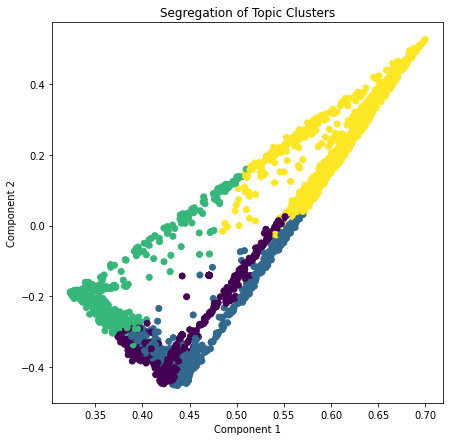

In [17]:
# Plot
plt.figure(figsize=(7, 7))
plt.scatter(x, y, c=clusters)
plt.ylabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

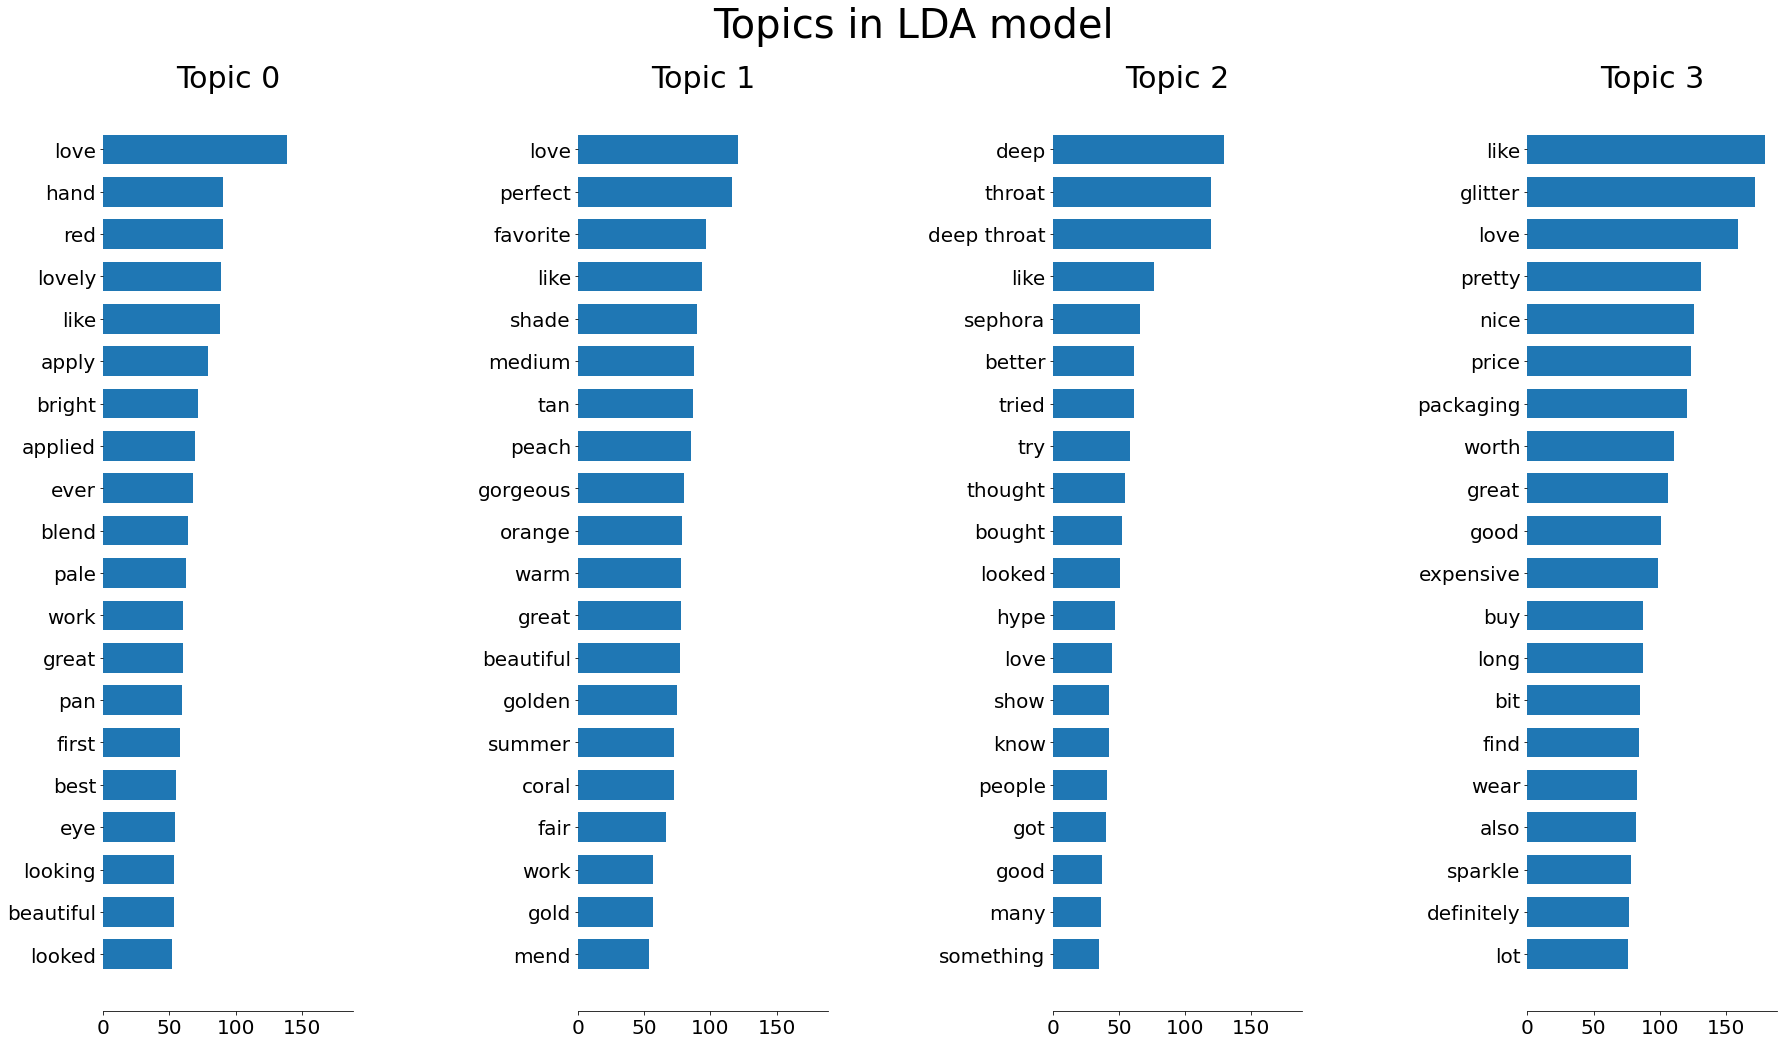

In [18]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 4, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

n_top_words = 20
words = tfidf_vectorizer.get_feature_names()
plot_top_words(best_lda_model, words, n_top_words, 'Topics in LDA model')

In [19]:
# Reset index
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

In [20]:
# Add topic feature into products
X_train['dominant_topic'] = dominant_topic_train
X_test['dominant_topic'] = dominant_topic_test

In [21]:
X_train['dominant_topic'].value_counts()

3    1867
1    1217
0    1194
2     751
Name: dominant_topic, dtype: int64

In [22]:
X_test['dominant_topic'].value_counts()

3    616
1    401
0    389
2    271
Name: dominant_topic, dtype: int64

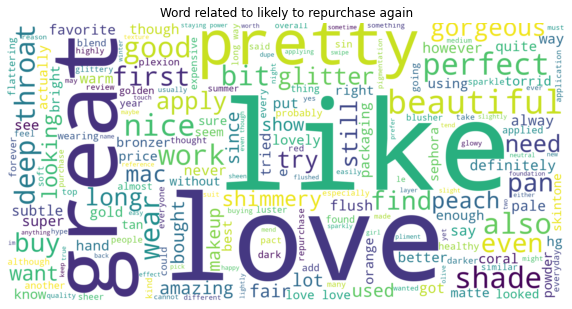

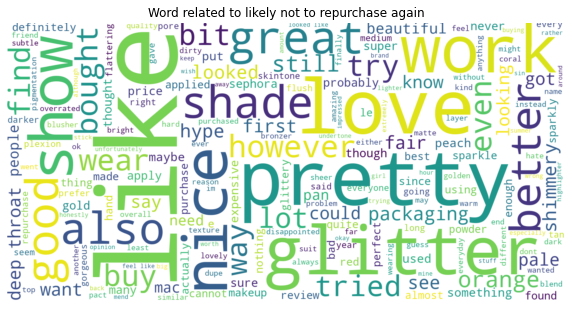

In [23]:
# Wordcloud
repurchase_products = df[df['repurchase_again'] == 1]
donot_repurchase_products = df[df['repurchase_again'] == 0]
repurchase_reviews = " ".join(r for r in repurchase_products['review_processed_stop'])
donot_repurchase_reviews = " ".join(r for r in donot_repurchase_products['review_processed_stop'])

# Create and generate a word cloud image that excludes domain-specific and common stopwords
repurchase_wordcloud = WordCloud(stopwords=stop, background_color="white", width=2000, height=1000).generate(repurchase_reviews)
donot_repurchase_wordcloud = WordCloud(stopwords=stop, background_color="white", width=2000, height=1000).generate(donot_repurchase_reviews)

# Display the generated image
plt.figure(figsize=(10, 7))
plt.imshow(repurchase_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word related to likely to repurchase again")
plt.show()

plt.figure(figsize=(10, 7))
plt.imshow(donot_repurchase_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word related to likely not to repurchase again")
plt.show()

# Model Building

In [24]:
# Check class distribution
y_train.value_counts()

1    3811
0    1218
Name: repurchase_again, dtype: int64

In [25]:
# Create Function Transformer to use Feature Union
def get_numeric_data(x):
    return x.drop(['review','review_processed','review_processed_stop'],axis=1)

def get_text_data(x):
    return x['review_processed']

transformer_numeric = FunctionTransformer(get_numeric_data)
transformer_text = FunctionTransformer(get_text_data)

In [26]:
# Training config
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
scoring = {'Recall': 'recall', 'Precision': 'precision', 'ROC_AUC': 'roc_auc', 'F1': 'f1_macro'}
refit = 'Recall'

## Logistic Regression

In [27]:
# Create a pipeline to concatenate Tfidf Vector and Numeric data
pipeline = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', transformer_numeric)
            ])),
             ('text_features', Pipeline([
                ('selector', transformer_text),
                ('vect', TfidfVectorizer())
            ]))
         ])),
    ('feature_selection', SelectFromModel(RandomForestClassifier(n_estimators=100))),
    ('logreg', LogisticRegression(solver='liblinear', random_state=0))
])

# Randomized Search Parameters for Log Reg
param_grid = {
              'features__text_features__vect__use_idf': (True, False),
              'features__text_features__vect__max_df': (0.5, 0.75, 1.0),
              'features__text_features__vect__min_df': (0.01, 0.03, 0.05),
              'features__text_features__vect__stop_words': (None, stop, 'english'),
              'features__text_features__vect__ngram_range': ((1, 1), (1, 2)), # unigrams or bigrams
              'logreg__C': (0.01, 1, 10),
              'logreg__penalty': ('l1', 'l2'),
             }


# Perform Randomized Search
logreg = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=100, cv=kfold, scoring=scoring, refit=refit, n_jobs=-1, verbose=1, random_state=0, return_train_score=True)

#t0 = time()
logreg.fit(X_train,y_train)
#print("done in %0.3fs" % (time() - t0))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
                   estimator=Pipeline(steps=[('features',
                                              FeatureUnion(transformer_list=[('numeric_features',
                                                                              Pipeline(steps=[('selector',
                                                                                               FunctionTransformer(func=<function get_numeric_data at 0x000001A27D4758C8>))])),
                                                                             ('text_features',
                                                                              Pipeline(steps=[('selector',
                                                                                               FunctionTransformer(func=<functio...
                                                                                       'himself',
                                                

In [28]:
# Save to file
joblib.dump(logreg, 'models/logreg.pkl')

['models/logreg.pkl']

In [29]:
# Load file
logreg = joblib.load('models/logreg.pkl')

In [30]:
# Model prediction
y_pred_logreg = logreg.predict(X_test)
y_pred_logreg_proba = logreg.predict_proba(X_test)[:, 1]

In [31]:
# Evaluation
print('Accuracy:', accuracy_score(y_test, y_pred_logreg))
print('Precision:', precision_score(y_test, y_pred_logreg))
print('Recall:', recall_score(y_test, y_pred_logreg))
print('ROC_AUC:', roc_auc_score(y_test, y_pred_logreg_proba))

print('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred_logreg))

print('\nClassification Report:')
print(classification_report(y_test, y_pred_logreg))

Accuracy: 0.7608825283243887
Precision: 0.7613567534827377
Recall: 0.9944620253164557
ROC_AUC: 0.7680659423177123

Confusion Matrix:
[[  19  394]
 [   7 1257]]

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.05      0.09       413
           1       0.76      0.99      0.86      1264

    accuracy                           0.76      1677
   macro avg       0.75      0.52      0.47      1677
weighted avg       0.75      0.76      0.67      1677



## SVM

In [32]:
# Create a pipeline to concatenate Tfidf Vector and Numeric data
pipeline = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', transformer_numeric)
            ])),
             ('text_features', Pipeline([
                ('selector', transformer_text),
                ('vect', TfidfVectorizer())
            ]))
         ])),
    ('feature_selection', SelectFromModel(RandomForestClassifier(n_estimators=100))),
    ('svm', SVC(probability=True, random_state=0))
])

# Randomized Search Parameters for SVM
param_grid = {
              'features__text_features__vect__max_df': (0.5, 0.75, 1.0),
              'features__text_features__vect__min_df': (0.01, 0.03, 0.05),
              'features__text_features__vect__stop_words': (None, stop, 'english'),
              'features__text_features__vect__ngram_range': ((1, 1), (1, 2)), # unigrams or bigrams
              'svm__C': (0.1, 1, 10), 
              'svm__gamma': (1, 0.1, 0.01),
              'svm__kernel': ('linear', 'rbf', 'poly', 'sigmoid')
             }


# Perform Randomized Search
svm = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=100, cv=kfold, scoring=scoring, refit=refit, n_jobs=-1, verbose=1, random_state=0, return_train_score=True)

#t0 = time()
svm.fit(X_train,y_train)
#print("done in %0.3fs" % (time() - t0))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
                   estimator=Pipeline(steps=[('features',
                                              FeatureUnion(transformer_list=[('numeric_features',
                                                                              Pipeline(steps=[('selector',
                                                                                               FunctionTransformer(func=<function get_numeric_data at 0x000001A27D4758C8>))])),
                                                                             ('text_features',
                                                                              Pipeline(steps=[('selector',
                                                                                               FunctionTransformer(func=<functio...
                                                                                       'he',
                                                     

In [33]:
# Save to file
joblib.dump(svm, 'models/svm.pkl')

['models/svm.pkl']

In [34]:
# Load file
svm = joblib.load('models/svm.pkl')

In [35]:
# Model prediction
y_pred_svm = svm.predict(X_test)
y_pred_svm_proba = svm.predict_proba(X_test)[:, 1]

In [36]:
# Evaluation
print('Accuracy:', accuracy_score(y_test, y_pred_svm))
print('Precision:', precision_score(y_test, y_pred_svm))
print('Recall:', recall_score(y_test, y_pred_svm))
print('ROC_AUC:', roc_auc_score(y_test, y_pred_svm_proba))

print('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred_svm))

print('\nClassification Report:')
print(classification_report(y_test, y_pred_svm))

Accuracy: 0.753726893261777
Precision: 0.753726893261777
Recall: 1.0
ROC_AUC: 0.7907848561007754

Confusion Matrix:
[[   0  413]
 [   0 1264]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       413
           1       0.75      1.00      0.86      1264

    accuracy                           0.75      1677
   macro avg       0.38      0.50      0.43      1677
weighted avg       0.57      0.75      0.65      1677

C:\Users\carin\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\carin\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are

## Naive Bayes

In [37]:
# Create a pipeline to concatenate Tfidf Vector and Numeric data
pipeline = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', transformer_numeric)
            ])),
             ('text_features', Pipeline([
                ('selector', transformer_text),
                ('vect', TfidfVectorizer())
            ]))
         ])),
    ('feature_selection', SelectFromModel(RandomForestClassifier(n_estimators=100))),
    ('nb', MultinomialNB())
])

# Randomized Search Parameters for Naive Bayes
param_grid = {
              'features__text_features__vect__max_df': (0.5, 0.75, 1.0),
              'features__text_features__vect__min_df': (0.01, 0.03, 0.05),
              'features__text_features__vect__stop_words': (None, stop, 'english'),
              'features__text_features__vect__ngram_range': ((1, 1), (1, 2)), # unigrams or bigrams
              'nb__alpha': (0.0001, 0.01, 1, 10)
             }


# Perform Randomized Search
nb = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=100, cv=kfold, scoring=scoring, refit=refit, n_jobs=-1, verbose=1, random_state=0, return_train_score=True)

#t0 = time()
nb.fit(X_train,y_train)
#print("done in %0.3fs" % (time() - t0))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
                   estimator=Pipeline(steps=[('features',
                                              FeatureUnion(transformer_list=[('numeric_features',
                                                                              Pipeline(steps=[('selector',
                                                                                               FunctionTransformer(func=<function get_numeric_data at 0x000001A27D4758C8>))])),
                                                                             ('text_features',
                                                                              Pipeline(steps=[('selector',
                                                                                               FunctionTransformer(func=<functio...
                                                                                       "you've",
                                                 

In [38]:
# Save to file
joblib.dump(nb, 'models/nb.pkl')

['models/nb.pkl']

In [39]:
# Load file
nb = joblib.load('models/nb.pkl')

In [40]:
# Model prediction
y_pred_nb = nb.predict(X_test)
y_pred_nb_proba = nb.predict_proba(X_test)[:, 1]

In [41]:
# Evaluation
print('Accuracy:', accuracy_score(y_test, y_pred_nb))
print('Precision:', precision_score(y_test, y_pred_nb))
print('Recall:', recall_score(y_test, y_pred_nb))
print('ROC_AUC:', roc_auc_score(y_test, y_pred_nb_proba))

print('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred_nb))

print('\nClassification Report:')
print(classification_report(y_test, y_pred_nb))

Accuracy: 0.7656529516994633
Precision: 0.7628243814121907
Recall: 1.0
ROC_AUC: 0.8193693106935973

Confusion Matrix:
[[  20  393]
 [   0 1264]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.05      0.09       413
           1       0.76      1.00      0.87      1264

    accuracy                           0.77      1677
   macro avg       0.88      0.52      0.48      1677
weighted avg       0.82      0.77      0.68      1677



# Stacking

In [ ]:
from sklearn.ensemble import StackingClassifier